All libraries imported!
Area of interest defined.
Simulated NDVI, densities, and temperature prepared.
Training dataset created with 10000 samples.


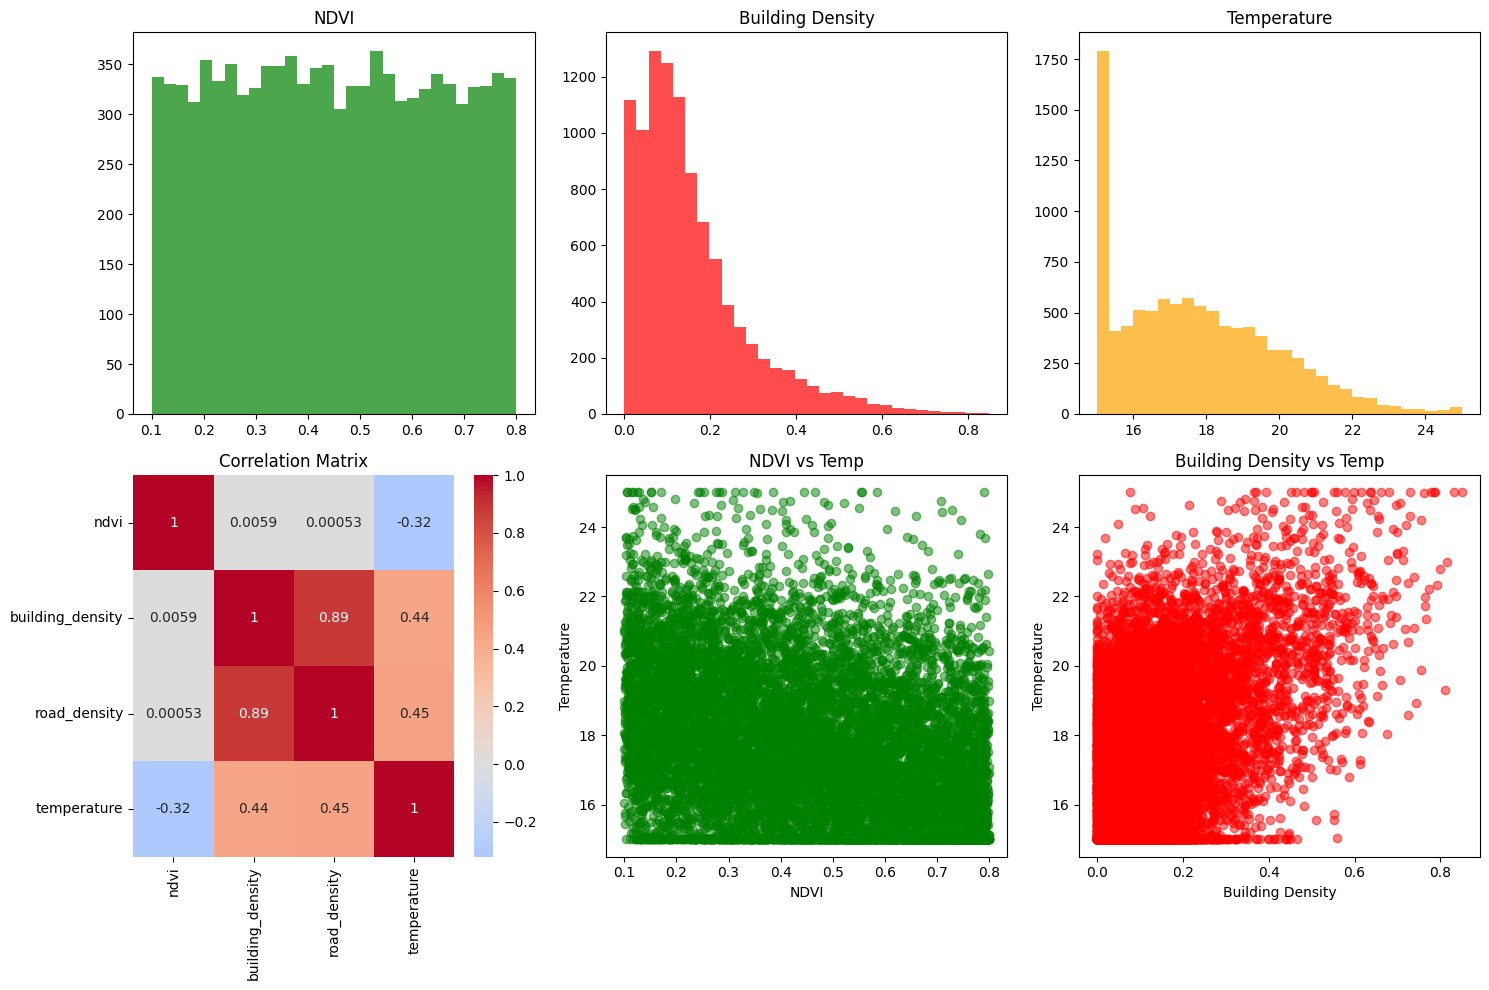

Training set: (8000, 3), Testing set: (2000, 3)
Random Forest R²: 0.2920089013103637
XGBoost R²: 0.28287132165722384
Best model: Random Forest
Predicted temperature heat map generated.
Rural baseline: 16.88°C, Max UHI: 7.54°C, Avg UHI: 0.84°C


C:\Users\ctewa\anaconda3\envs\mynew2\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


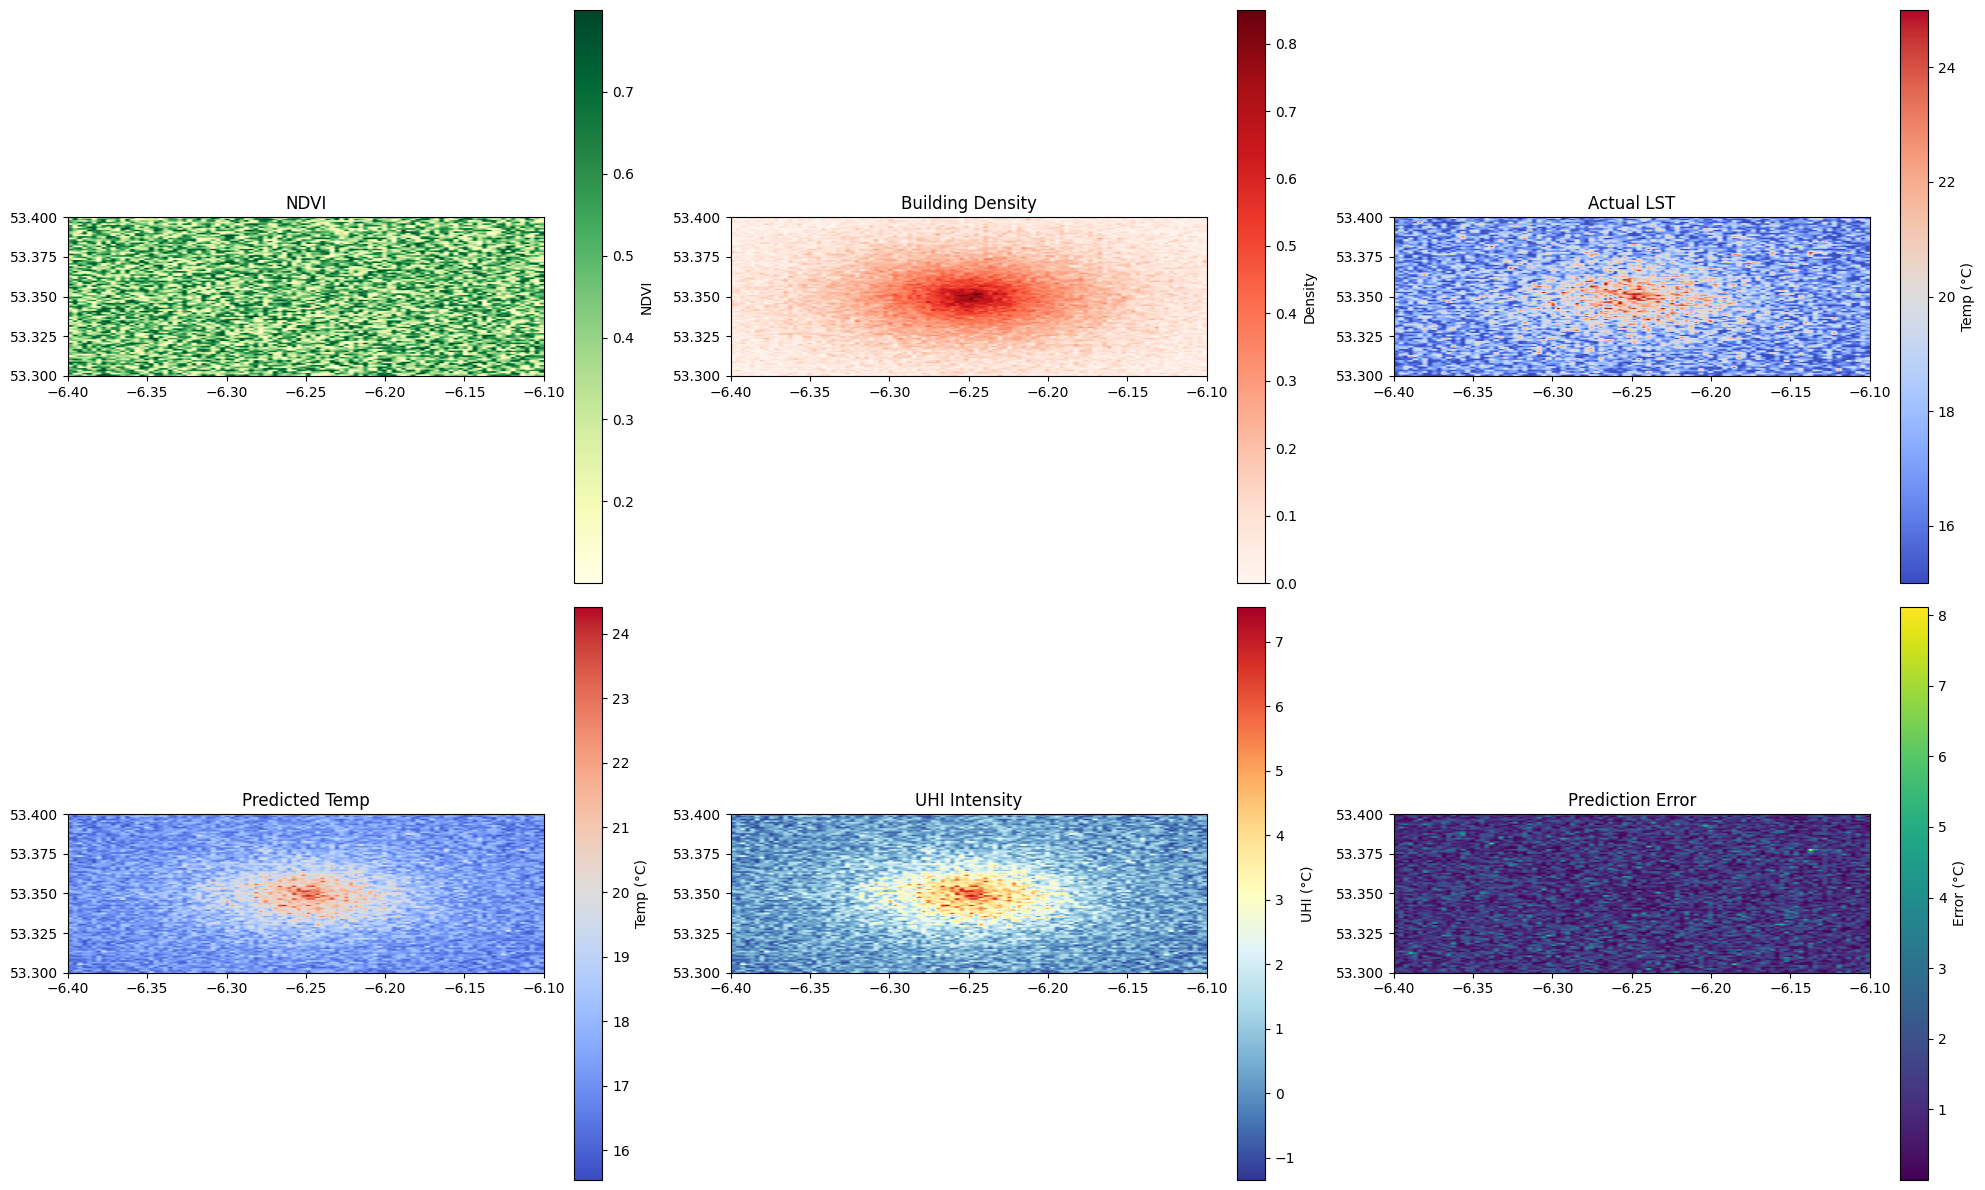

In [9]:
# ================================
# Cell 1: Import libraries
# ================================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
import folium
from folium import plugins

print("All libraries imported!")

# ================================
# Cell 2: Define Area of Interest
# ================================
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [-6.4, 53.3], [-6.1, 53.3], 
        [-6.1, 53.4], [-6.4, 53.4], 
        [-6.4, 53.3]
    ]]
}
print("Area of interest defined.")

# ================================
# Cell 3: Generate Realistic Simulated Data
# ================================
grid_size = 100

# Coordinate grid
coords = area_of_interest['coordinates'][0]
west, east = min(c[0] for c in coords), max(c[0] for c in coords)
south, north = min(c[1] for c in coords), max(c[1] for c in coords)
lon_array = np.linspace(west, east, grid_size)
lat_array = np.linspace(south, north, grid_size)
lon_grid, lat_grid = np.meshgrid(lon_array, lat_array)

# NDVI - more vegetation in outskirts
final_ndvi = np.random.uniform(0.1, 0.8, (grid_size, grid_size))

# Building density - higher in city center
center_x, center_y = grid_size//2, grid_size//2
y_idx, x_idx = np.ogrid[:grid_size, :grid_size]
dist_from_center = np.sqrt((x_idx - center_x)**2 + (y_idx - center_y)**2)
building_density_final = np.clip(0.8 * np.exp(-dist_from_center/20) + np.random.normal(0, 0.05, (grid_size, grid_size)), 0, 1)
road_density_final = np.clip(0.6 * np.exp(-dist_from_center/25) + np.random.normal(0, 0.03, (grid_size, grid_size)), 0, 1)

# Land Surface Temperature with urban heat effect
lst_base = np.random.normal(18, 2, (grid_size, grid_size))
urban_heat_effect = np.exp(-dist_from_center / 20) * 7
final_lst = np.clip(lst_base + urban_heat_effect - final_ndvi*4, 15, 25)

print("Simulated NDVI, densities, and temperature prepared.")

# ================================
# Cell 4: Create Training Dataset
# ================================
def create_training_dataset(ndvi, building_density, road_density, lst, lon_grid, lat_grid):
    height, width = ndvi.shape
    data = []
    for i in range(height):
        for j in range(width):
            data.append({
                'ndvi': ndvi[i,j],
                'building_density': building_density[i,j],
                'road_density': road_density[i,j],
                'temperature': lst[i,j],
                'longitude': lon_grid[i,j],
                'latitude': lat_grid[i,j],
                'x': j,
                'y': i
            })
    return pd.DataFrame(data)

df = create_training_dataset(final_ndvi, building_density_final, road_density_final, final_lst, lon_grid, lat_grid)
print(f"Training dataset created with {len(df)} samples.")

# ================================
# Cell 5: Explore Data
# ================================
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); plt.hist(df['ndvi'], bins=30, color='green', alpha=0.7); plt.title('NDVI')
plt.subplot(2,3,2); plt.hist(df['building_density'], bins=30, color='red', alpha=0.7); plt.title('Building Density')
plt.subplot(2,3,3); plt.hist(df['temperature'], bins=30, color='orange', alpha=0.7); plt.title('Temperature')
plt.subplot(2,3,4); sns.heatmap(df[['ndvi','building_density','road_density','temperature']].corr(), annot=True, cmap='coolwarm', center=0); plt.title('Correlation Matrix')
plt.subplot(2,3,5); plt.scatter(df['ndvi'], df['temperature'], c='green', alpha=0.5); plt.xlabel('NDVI'); plt.ylabel('Temperature'); plt.title('NDVI vs Temp')
plt.subplot(2,3,6); plt.scatter(df['building_density'], df['temperature'], c='red', alpha=0.5); plt.xlabel('Building Density'); plt.ylabel('Temperature'); plt.title('Building Density vs Temp')
plt.tight_layout(); plt.show()

# ================================
# Cell 6: Prepare ML Data
# ================================
X = df[['ndvi', 'building_density', 'road_density']]
y = df['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# ================================
# Cell 7: Train Models
# ================================
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

# Select best model
best_model = rf_model if rf_r2 > xgb_r2 else xgb_model
best_model_name = 'Random Forest' if best_model == rf_model else 'XGBoost'

print("Random Forest R²:", rf_r2)
print("XGBoost R²:", xgb_r2)
print("Best model:", best_model_name)

# ================================
# Cell 8: Predict Heat Map (Vectorized)
# ================================
grid_features = np.stack([final_ndvi.ravel(), building_density_final.ravel(), road_density_final.ravel()], axis=1)
predicted_lst = best_model.predict(grid_features).reshape(grid_size, grid_size)
print("Predicted temperature heat map generated.")

# ================================
# Cell 9: Calculate UHI Intensity
# ================================
rural_mask = final_ndvi > 0.6
rural_baseline_temp = np.mean(final_lst[rural_mask])
uhi_intensity = predicted_lst - rural_baseline_temp

print(f"Rural baseline: {rural_baseline_temp:.2f}°C, Max UHI: {uhi_intensity.max():.2f}°C, Avg UHI: {uhi_intensity.mean():.2f}°C")

# ================================
# Cell 10: Visualize Results
# ================================
plt.figure(figsize=(20,12))
plt.subplot(2,3,1); plt.imshow(final_ndvi, cmap='YlGn', extent=[west,east,south,north]); plt.colorbar(label='NDVI'); plt.title('NDVI')
plt.subplot(2,3,2); plt.imshow(building_density_final, cmap='Reds', extent=[west,east,south,north]); plt.colorbar(label='Density'); plt.title('Building Density')
plt.subplot(2,3,3); plt.imshow(final_lst, cmap='coolwarm', extent=[west,east,south,north]); plt.colorbar(label='Temp (°C)'); plt.title('Actual LST')
plt.subplot(2,3,4); plt.imshow(predicted_lst, cmap='coolwarm', extent=[west,east,south,north]); plt.colorbar(label='Temp (°C)'); plt.title('Predicted Temp')
plt.subplot(2,3,5); plt.imshow(uhi_intensity, cmap='RdYlBu_r', extent=[west,east,south,north]); plt.colorbar(label='UHI (°C)'); plt.title('UHI Intensity')
plt.subplot(2,3,6); plt.imshow(np.abs(predicted_lst-final_lst), cmap='viridis', extent=[west,east,south,north]); plt.colorbar(label='Error (°C)'); plt.title('Prediction Error')
plt.tight_layout(); plt.show()

# ================================
# Cell 11: Interactive Map
# ================================
def create_interactive_map(lon_grid, lat_grid, uhi_intensity):
    m = folium.Map(location=[(north+south)/2,(west+east)/2], zoom_start=12)
    heat_data = [[lat_grid[i,j], lon_grid[i,j], uhi_intensity[i,j]] 
                 for i in range(0, grid_size,2) for j in range(0, grid_size,2) if uhi_intensity[i,j]>0]
    plugins.HeatMap(heat_data, gradient={0.4:'blue',0.6:'lime',0.8:'yellow',1.0:'red'}, radius=15).add_to(m)
    return m

interactive_map = create_interactive_map(lon_grid, lat_grid, uhi_intensity)
interactive_map  # This will display the map in Jupyter Notebook

